# Exploratory Models

In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

# color palette 
import matplotlib.colors as cplt
c1 = '#6DB1BF' # cyan
c2 = '#315659' # blue
c3 = '#F98948' # orange
c4 = '#C0DA74' # green
c5 = '#859750' # dark green

data = pd.read_csv('Data/Processed.csv',index_col='url')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39466 entries, http://mashable.com/2013/01/07/amazon-instant-video-browser/ to http://mashable.com/2014/12/27/youtube-channels-2015/
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                39466 non-null  float64
 1   n_tokens_content              39466 non-null  float64
 2   n_unique_tokens               39466 non-null  float64
 3   n_non_stop_words              39466 non-null  float64
 4   n_non_stop_unique_tokens      39466 non-null  float64
 5   num_hrefs                     39466 non-null  float64
 6   num_self_hrefs                39466 non-null  float64
 7   num_imgs                      39466 non-null  float64
 8   num_videos                    39466 non-null  float64
 9   average_token_length          39466 non-null  float64
 10  num_keywords                  39466 non-null  float64
 11  self_reference_mi

# Random Forest Models

In [8]:
def best_depth(X,y,k,score):
    """
    Finds best depth of the model based off of the 
    """ 
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier())])
    grid = GridSearchCV(pipe,param_grid={'random_forest__max_depth':k},scoring=score)
    grid.fit(X,y)
    print(grid.best_params_)
    return grid

def make_model(X,y,depth_range=range(5,15),score='recall'):
    """
    Makes a random forest model based off the best K.
    """
    grid = best_depth(X.copy(),y.copy(),depth_range,score)

    depth = grid.best_params_['random_forest__max_depth']
    
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier(max_depth=depth))])
    pipe.fit(X,y)
    return pipe
        
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    Prints and plots a confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Rounding

Quickly see if a simple model can predict an articles share based on the features

### Random Forest

Text(0.5, 1.0, 'Test Accuracy')

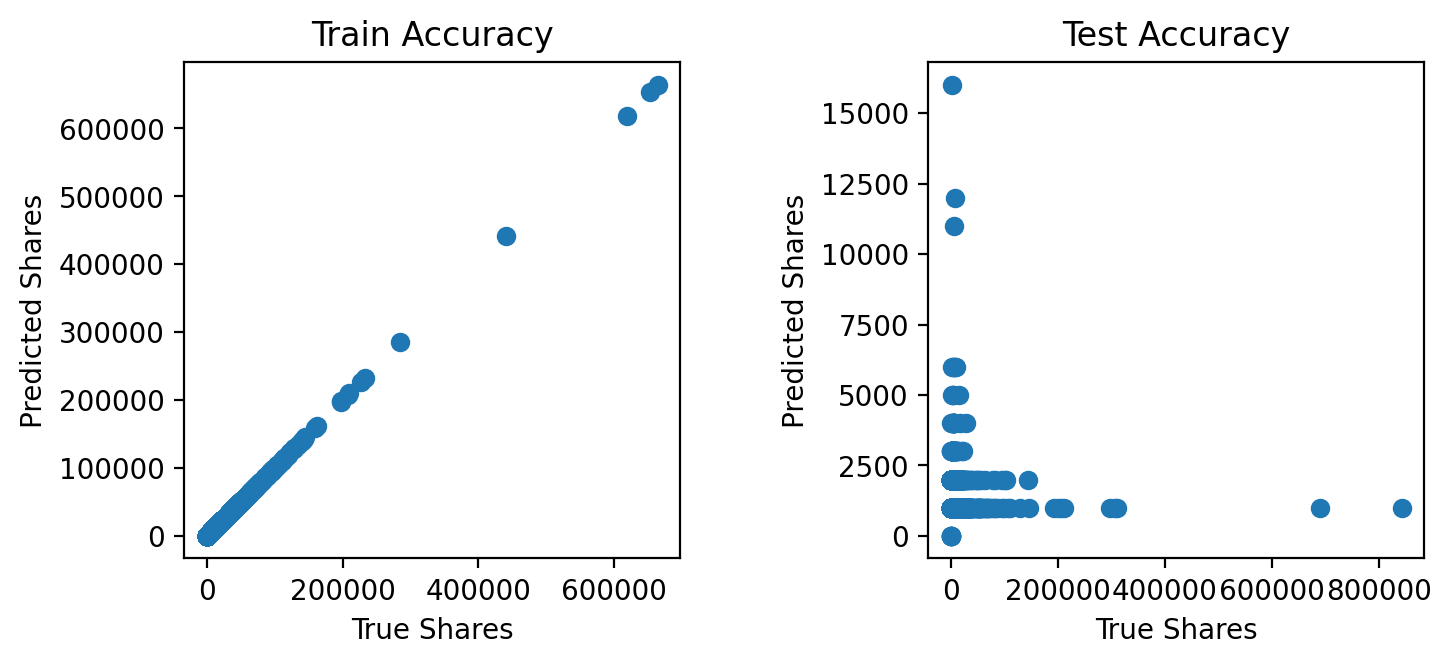

In [9]:
model_data_1 = data.copy()

# round shares to the closest thousand
model_data_1['rounded'] = model_data_1.shares.round(-3)
model_data_1 = model_data_1.drop(columns='shares')

y_var = 'rounded'

X = model_data_1.drop(columns=y_var)
y = model_data_1[y_var]

# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

# make model
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('RForest', RandomForestClassifier())])

# fit model and predict
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# plot accuracy
plt.figure(figsize=(8,4),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

ax1 = plt.subplot(121)
ax1.set_box_aspect(1)
plt.scatter(y_train,y_pred_train)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Train Accuracy')

ax2 = plt.subplot(122)
ax2.set_box_aspect(1)
plt.scatter(y_test,y_pred_test)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Test Accuracy')

### Linear Regression

Text(0.5, 1.0, 'Test Accuracy')

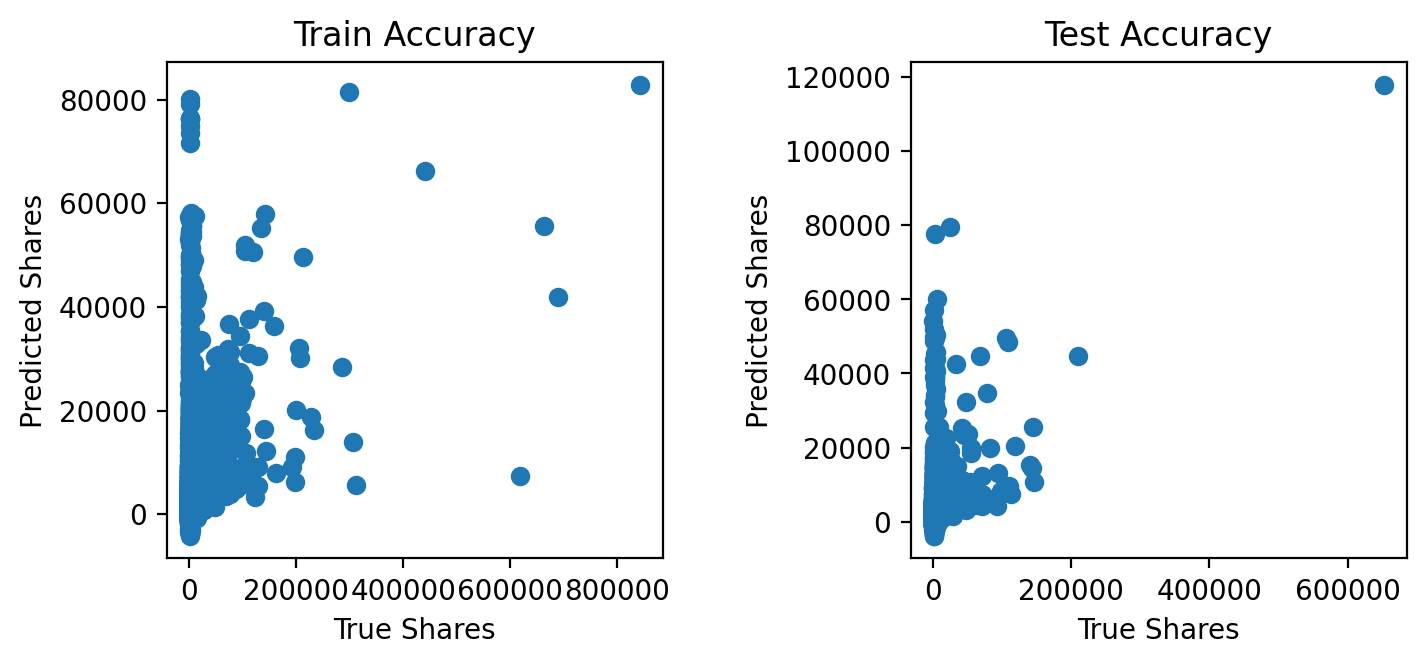

In [10]:
model_data_1 = data.copy()

# round shares to the closest thousand
model_data_1['rounded'] = model_data_1.shares.round(-3)
model_data_1 = model_data_1.drop(columns='shares')

y_var = 'rounded'

X = model_data_1.drop(columns=y_var)
y = model_data_1[y_var]

# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

# make model
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('LinReg', LinearRegression())])

# fit model and predict
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# plot accuracy
plt.figure(figsize=(8,4),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

ax1 = plt.subplot(121)
ax1.set_box_aspect(1)
plt.scatter(y_train,y_pred_train)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Train Accuracy')

ax2 = plt.subplot(122)
ax2.set_box_aspect(1)
plt.scatter(y_test,y_pred_test)
plt.xlabel('True Shares')
plt.ylabel('Predicted Shares')
plt.title('Test Accuracy')

Can't really predict shares with any accuracy. Lets try simplifying the criteria with a multi classification set-up instead.

# Three Brackets
Seperating the entries into three seperate brackets based on percentiles

In [11]:
model_data_2 = data.copy()

def popularity_3(data,col_name):
    """
    Labels data as 'popular','average' or 'unpopular' based on the 30th and 95th percentile
    """
    avg = int(np.percentile(data['shares'],[0,30])[1])
    high = int(np.percentile(data['shares'],[0,90])[1])
    
    data.loc[data[(data['shares'] > high)].index,col_name] = 'popular'
    data.loc[data[(data['shares'] >= avg) & (data['shares'] <= high)].index,col_name] = 'average'
    data.loc[data[data['shares'] < avg].index,col_name] = 'unpopular'
    return data.drop(columns='shares')
    
    return data

y_var = 'popularity'

model_data_2 = popularity_3(model_data_2,y_var)

y_var_values = model_data_2[y_var].unique()
X = model_data_2.drop(columns=y_var)
y = model_data_2[y_var].replace(y_var_values,range(len(y_var_values)))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,stratify=y)

# Print Distribution

def print_values(y_train,y_test):
    train = y_train.value_counts()
    train = train.append(pd.Series({'total':train.sum()}))
    train = pd.DataFrame(train,columns=['train'])

    test = y_test.value_counts()
    test = test.append(pd.Series({'total':test.sum()}))
    test = pd.DataFrame(test,columns=['test'])

    entries = train.join(test).T

    entries = entries.append(entries.sum().rename('total'))
    
    return(entries)
    
print_values(y_train,y_test)

,1,0,2,total
train,19476,8957,3139,31572
test,4870,2239,785,7894
total,24346,11196,3924,39466


{'random_forest__max_depth': 14}
0.7872165209679463 0.6478337978211299


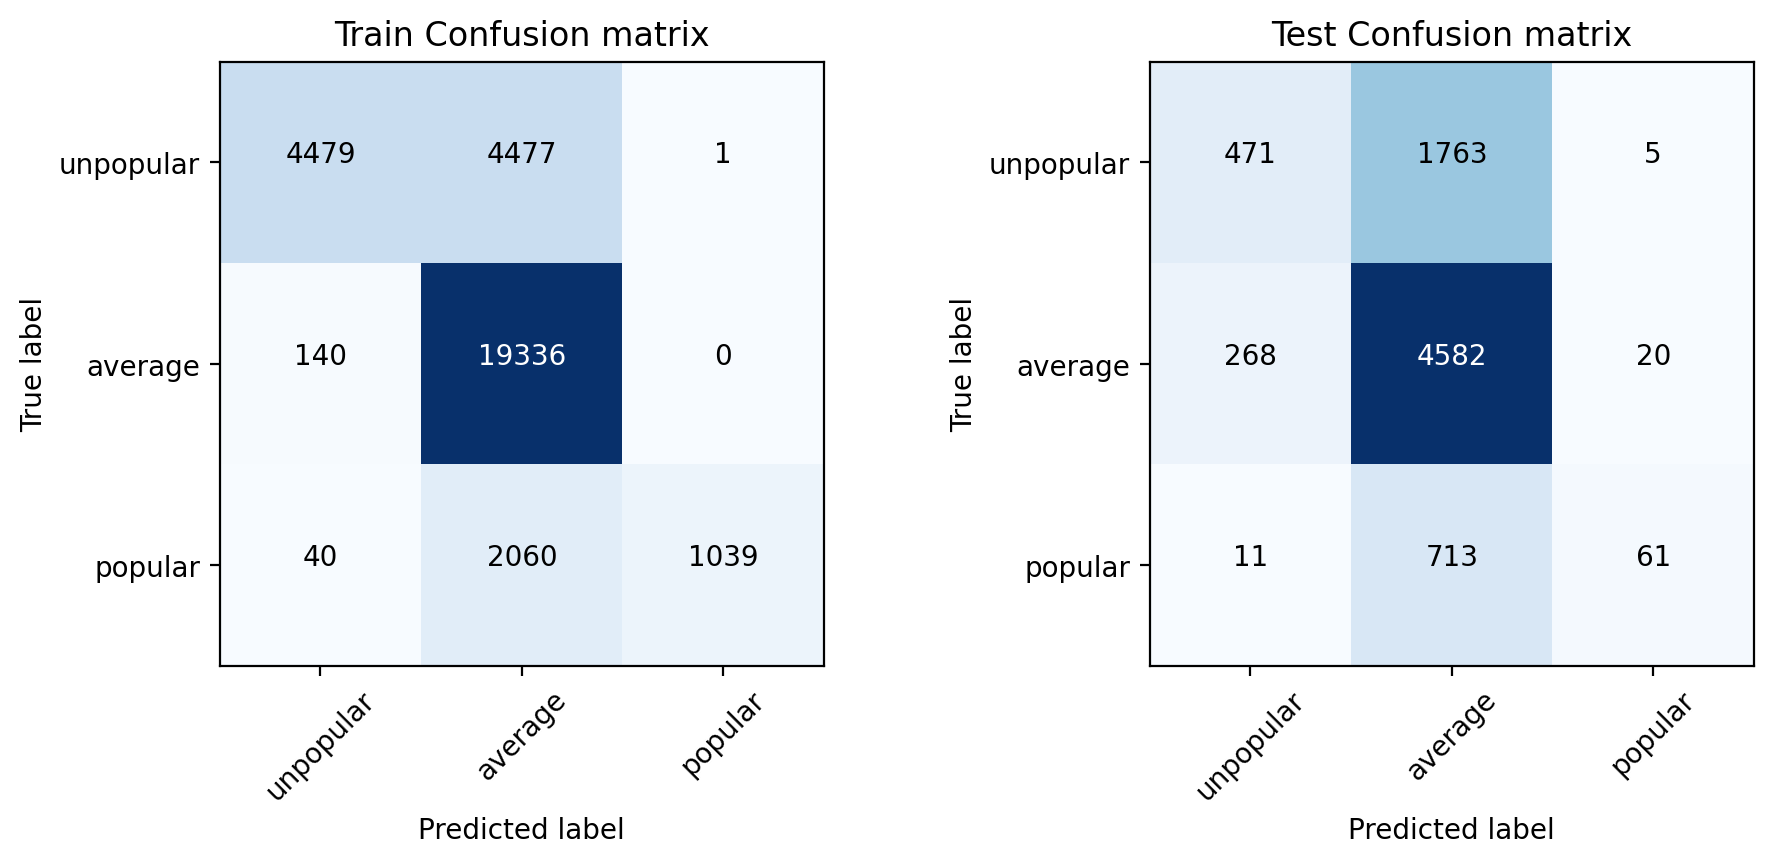

In [12]:
# Make model
model = make_model(X_train, y_train,depth_range=range(10,15),score='accuracy')

# Test model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

training_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(training_accuracy,test_accuracy)

cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Plot Confusion Matrix
plt.figure(figsize=(10,10),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

plt.subplot(221)
plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')

plt.subplot(222)
plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')

Seems it misclassifing alot of entries as `average`, probably since there are so many entries in that catergory. I'll try limiting the amount of entries so that there is an equal amount of all of them.

In [13]:
def lim_entries(X_train, X_test, y_train, y_test):
    '''
    Limits the points in the training set such that all all labels are equal.
    Adds cut points to the testing set. 
    '''
    y_var = y_train.name
    data = X_train.join(y_train)
    entries = list(data[y_var].value_counts().index[:-1])
    n = list(data[y_var].value_counts())[-1]
    new = data.loc[data[y_var] == data[y_var].value_counts().index[-1]]
    
    for entry in entries:
        selected = data[data[y_var] == entry].reset_index()
        selected_col = selected.columns
        index = selected_col[0]
        selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
        new = new.append(selected) 
        
    cut = data.drop(index=list(new.index))
    
    X_train = new.drop(columns=y_var)
    y_train = new[y_var]
    X_test = X_test.append(cut.drop(columns=y_var))
    y_test = y_test.append(cut[y_var])

    return X_train.astype('float'), X_test.astype('float'), y_train.astype('float'), y_test.astype('float')

# Split data
X_train_lim, X_test_lim, y_train_lim, y_test_lim = lim_entries(X_train, X_test, y_train, y_test)
print_values(y_train_lim,y_test_lim)

,0.0,1.0,2.0,total
train,3139,3139,3139,9417
test,8057,21207,785,30049
total,11196,24346,3924,39466


{'random_forest__max_depth': 10}
0.7990867579908676 0.43858364671037303


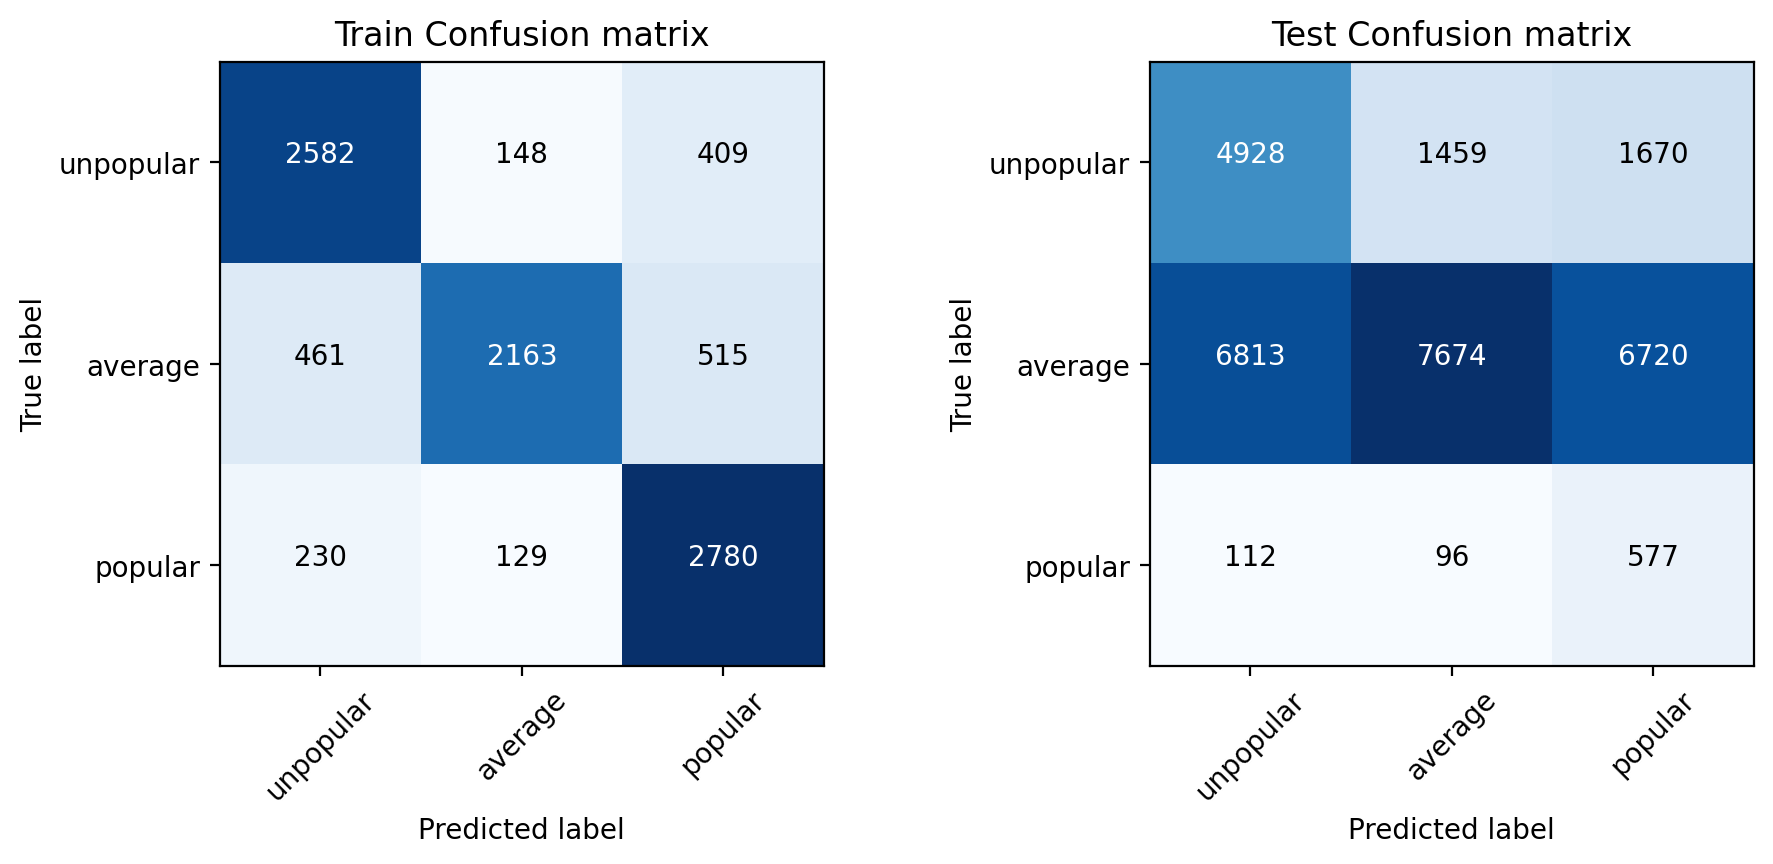

In [14]:
# Make model
model = make_model(X_train_lim, y_train_lim,depth_range=range(10,15),score='accuracy')

# Test model
y_pred_train = model.predict(X_train_lim)
y_pred_test = model.predict(X_test_lim)

training_accuracy = accuracy_score(y_train_lim, y_pred_train)
test_accuracy = accuracy_score(y_test_lim, y_pred_test)
print(training_accuracy,test_accuracy)

cnf_matrix_test = confusion_matrix(y_test_lim, y_pred_test)
cnf_matrix_train = confusion_matrix(y_train_lim, y_pred_train)

# Plot Confusion Matrix
plt.figure(figsize=(10,10),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)

plt.subplot(221)
plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')

plt.subplot(222)
plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')

Confusion matrix looks better but the true positives went down by alot. Since ultimatley we want to identify popular articles, Ill try binary classification with the same popular threshold.

# Binary Classification
Split entries into popular and unpopular

In [15]:
model_data_3 = data.copy()
pop = np.percentile(model_data_3.shares,[0,90])[1]

def popularity_2(data,thresh,col_name):
    """
    Labels data as 'popular' or 'unpopular' based on a given threshold.
    """
    data.loc[data[(data['shares'] > thresh)].index,col_name] = 'popular'
    data.loc[data[data['shares'] <= thresh].index,col_name] = 'unpopular'
    return data.drop(columns='shares')

# Split data
y_var = 'popularity'

model_data_3 = popularity_2(model_data_3,pop,y_var)

y_var_values = model_data_3[y_var].unique()
X = model_data_3.drop(columns=y_var)
y = model_data_3[y_var].replace(y_var_values,range(len(y_var_values)))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,stratify=y)

print_values(y_train,y_test)

,0,1,total
train,28433,3139,31572
test,7109,785,7894
total,35542,3924,39466


{'random_forest__max_depth': 14}
Accuracy: 0.9415304700367414 0.9068913098555865
F1 score: 0.5834837545126353 0.15420023014959724


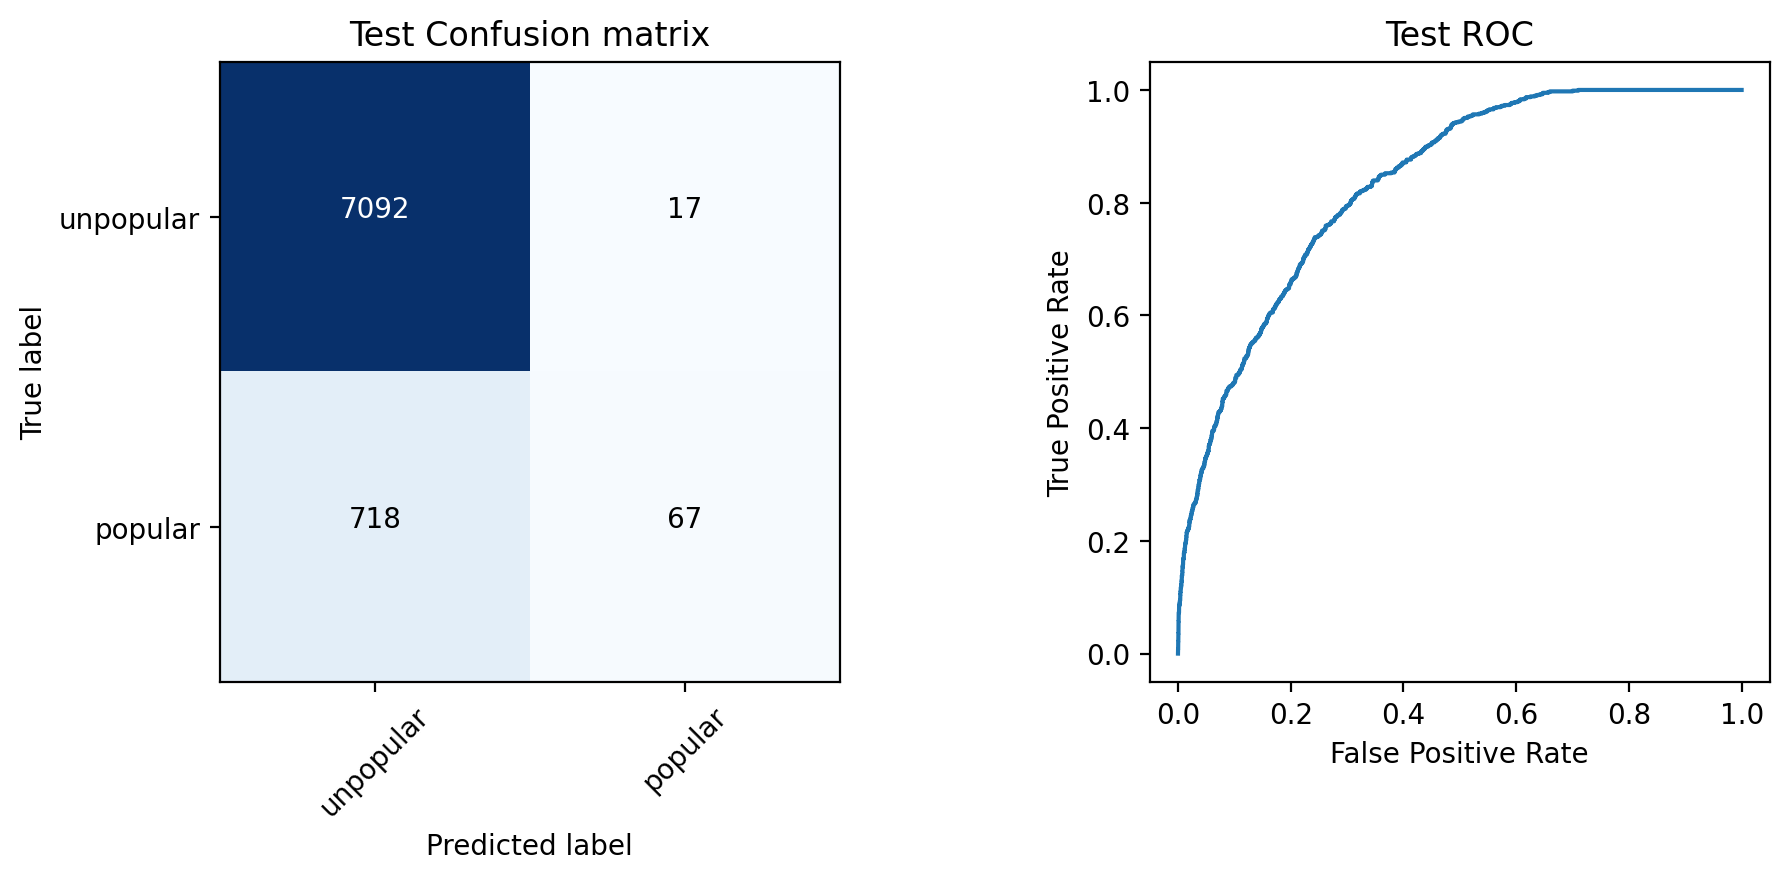

In [16]:
# Make model
model = make_model(X_train, y_train,depth_range=range(10,15),score='f1')

# Test model
def test_model(model,X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_pred_train_proba = model.predict_proba(X_train)[:, 1]
    y_pred_test_proba = model.predict_proba(X_test)[:, 1]

    # accuracy
    training_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print('Accuracy:',training_accuracy,test_accuracy)
    
    # f1 score
    training_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    print('F1 score:',training_f1,test_f1)

    # confusion matrix
    cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
    cnf_matrix_train = confusion_matrix(y_train, y_pred_train)

    # roc curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)

    
    # Set up figures
    plt.figure(figsize=(10,10),dpi=200)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
    # Plot Confusion Matrix
    ax1=plt.subplot(121)
    plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')

    # Plot ROC Curve
    ax2=plt.subplot(122)
    ax2.set_box_aspect(1)
    plt.title('Test ROC')
    plt.plot(fpr_test, tpr_test)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');
    
test_model(model,X_train, X_test, y_train, y_test)

# Binary Classificaiton - Limited

In [18]:
# limit points
X_train_lim, X_test_lim, y_train_lim, y_test_lim = lim_entries(X_train, X_test, y_train, y_test)
print_values(y_train_lim,y_test_lim)

,0.0,1.0,total
train,3139,3139,6278
test,32403,785,33188
total,35542,3924,39466


{'random_forest__max_depth': 10}
Accuracy: 0.8918445364765849 0.6899783054115946
F1 score: 0.8948428062567756 0.11002508433526512


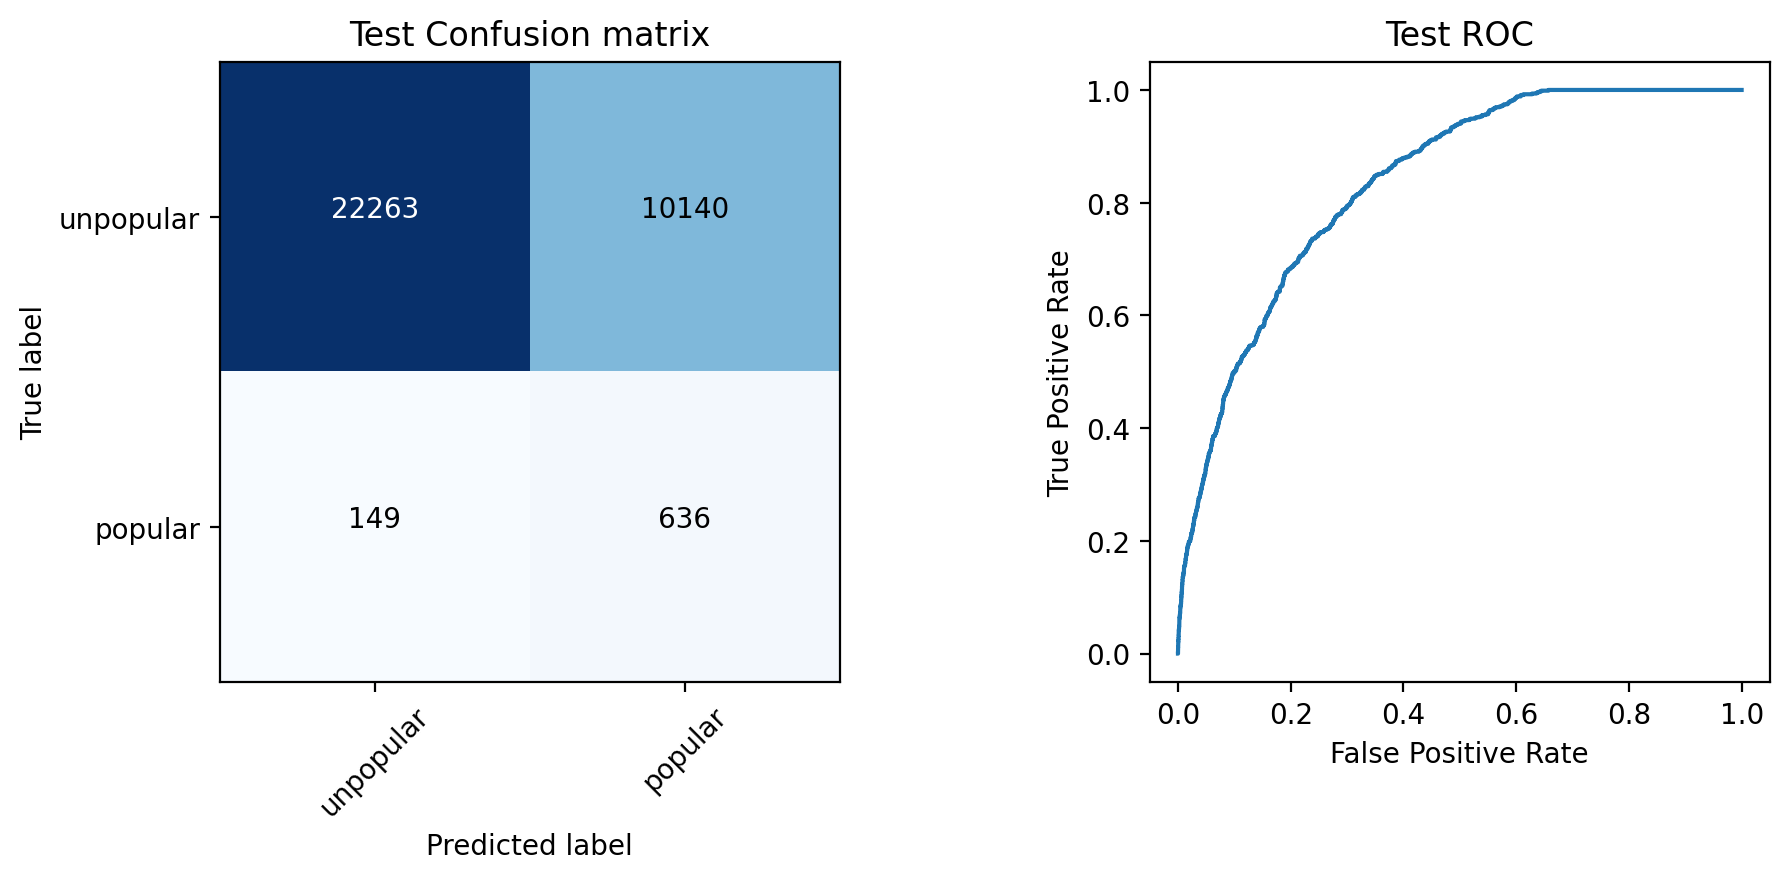

In [19]:
# Make model
model = make_model(X_train_lim, y_train_lim,depth_range=range(10,15),score='f1')
test_model(model,X_train_lim, X_test_lim, y_train_lim, y_test_lim)

So the limited data point model manages to correctly identify 85% of the popular articles, while the unlimited points model has a true positve accuracy of 80%, maybe theres a way to combine these models such that it can both correctly identify popular articles with a high enough certaining that all articles labeled popular are indeed popular.

Overall, the binary classification does the best. I'll move forwards to optimizing this model.